In [3]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim.lr_scheduler import StepLR
import clip

from sklearn.metrics import accuracy_score, f1_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Download Dataset**

Download the dataset from [this Kaggle link](https://www.kaggle.com/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp) and unzip it under your project folder


The entire possible answers form the answer space and the model answer questioned image by classifying the answer from answer space.


In [4]:
# load dataset
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("..","dataset","data_train.csv"),
        "test": os.path.join("..","dataset", "data_eval.csv")
    }
)

with open(os.path.join("..","dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

image167


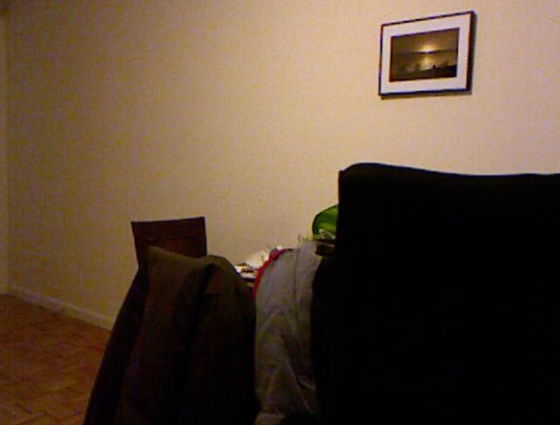

Question:	 what color is the floor in this picture
Answer:		 brown (Label: 76)


In [5]:
# show instance of dataset
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    print(data[id]["image_id"])
    image = Image.open(os.path.join("..","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

showExample()

In [6]:
# build tokenizer for question

from collections import defaultdict

train_dataset_loader = DataLoader(dataset["train"], batch_size=1, shuffle=False)

# Initialize the vocabulary with special tokens
q2i = defaultdict(lambda: len(q2i))
q2i['<pad>'] = 0  # Padding token
q2i['<unk>'] = 1  # Unknown word token

# Loop through the training data to build the vocabulary
for batch_id, batch in enumerate(train_dataset_loader):
    question = batch['question'][0]  
    words = question.lower().strip().split(" ")
    [q2i[word] for word in words]

q2i.default_factory = None
#print(q2i, len(q2i))

**Constructing Model**

In [8]:
from torchvision.models import googlenet

class SimpleBaseline(nn.Module):
    """
    Predicts an answer to a question about an image using the Hierarchical Question-Image Co-Attention
    for Visual Question Answering (Lu et al, 2017) paper.
    """
    def __init__(self, num_embeddings, num_classes):
        super().__init__()

        self.gnet = googlenet(pretrained=True)
        self.gnet.fc = nn.Identity()
        for param in self.gnet.parameters():
            param.requires_grad = False
        
        self.embed = nn.Linear(num_embeddings, 1024)
        self.fc = nn.Linear(1024 + 1024, num_classes)

    def forward(self, image, question):
        # process image
        transform = ToTensor()
        image_tensor = transform(image)
        image_tensor = image_tensor.unsqueeze(0).to('cuda')
        img = self.gnet(image_tensor)

        # process question
        question = tokenize_question(question, q2i).to('cuda')
        #print(question)
        unique_question = torch.unique(question)  # Get unique integers from the question
        question = F.one_hot(unique_question, num_classes=len(q2i)).sum(dim=0).float()  # One-hot encode the question
        #print(torch.nonzero(question).squeeze(), question.shape, sum(question))
        ques = self.embed(question)
        ques = ques.unsqueeze(0)  # Add batch dimension

        con = torch.cat((img, ques), dim=1)
        return self.fc(con)

def tokenize_question(question, q2i):
    return torch.tensor([q2i.get(word, q2i['<unk>']) for word in question.lower().strip().split(" ")])

In [85]:
trainDataset = dataset['train']
subset_size = 1
subset_indices = list(range(subset_size))
SubDataset = Subset(trainDataset, subset_indices)
train_dataset_loader = DataLoader(SubDataset, batch_size=1, shuffle=True)

model = SimpleBaseline(len(q2i), 582)
model.to('cuda')

for batch_id, batch in enumerate(train_dataset_loader):
    image_id = batch['image_id'][0]
    labels = batch['label']
    
    
    question = batch['question'][0]
    image = Image.open(os.path.join("..","dataset", "images", image_id + ".png"))
    
    predicted_logits = model(image, question)
    print(predicted_logits.shape)

torch.Size([1, 582])


In [86]:
model = SimpleBaseline(len(q2i), 582)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of learnable parameters: {total_params}")

embed.weight torch.Size([1024, 1014])
embed.bias torch.Size([1024])
fc.weight torch.Size([582, 2048])
fc.bias torch.Size([582])
Total number of learnable parameters: 2231878


In [98]:
class Model():
    def __init__(self, dataset, batch_size, num_epochs, lr=0.001, num_classes=582, check=False, save=False, checkpoint_epoch=0):
        self.num_classes = num_classes
        self.check = check
        self.save = save
        self.checkpoint_epoch = checkpoint_epoch

        self.model = SimpleBaseline(len(q2i), 582)
        
        self._num_epochs = num_epochs
        self._batch_size = batch_size
        self._lr = lr

        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.DEVICE)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.initialize_weights()

        self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.6)

        trainDataset = dataset['train']
        subset_size = len(trainDataset)
        subset_indices = list(range(subset_size))
        SubDataset = Subset(trainDataset, subset_indices)
        self.train_dataset_loader = DataLoader(SubDataset, batch_size=1, shuffle=True)
        #self.val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)

    def initialize_weights(self):
      for layer in self.model.modules():
          if not isinstance(layer, (nn.Conv2d, nn.Linear)):
              continue
          try:
              torch.nn.init.xavier_normal_(layer.weight)
              try:
                  nn.init.constant_(layer.bias.data, 0)
              except:
                  pass
          except:
              pass

    def train(self):
        train_losses = []
        print('Started Training.\n')
        for epoch in range(self._num_epochs - self.checkpoint_epoch):
            train_epcoh = self.checkpoint_epoch + epoch + 1
            if self.check:
                total_matches = 0
                total_samples = 0
                TP = 0
                FN = 0
                FP = 0
                TN = 0
      
            self.model.train()  # Set the model to training mode
            train_loss = 0.0
            for batch_id, batch in enumerate(self.train_dataset_loader):
                image_id = batch['image_id'][0]
                labels = batch['label']

                true_answer = torch.zeros(1, self.num_classes, dtype=torch.float32)
                for label in labels:
                    true_answer[0][label] = 1

                true_answer = true_answer.to(self.DEVICE)
                
                question = batch['question'][0]
                image = Image.open(os.path.join("..","dataset", "images", image_id + ".png"))

                predicted_logits = self.model(image, question)
                #print(predicted_logits.shape)
                
                self.optimizer.zero_grad()
                loss = self.criterion(predicted_logits, true_answer)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

                if self.check:
                    predicted_probs = torch.softmax(predicted_logits, dim=1)
                    predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities
        
                    for j in range (0, len(predicted_labels[0])):
                        if predicted_labels[0][j] == 1:
                            if j in labels:
                                TP += 1
                            else:
                                FP += 1
                        else:
                            if j in labels:
                                FN += 1
                            else:
                                TN += 1
        
                    total_matches += ((predicted_labels == true_answer).sum()).item()
                    total_samples += len(labels)
                    
                if batch_id % 100 == 0:  # Log every 100 batches
                    print(f'Epoch [{train_epcoh}/{self._num_epochs+self.checkpoint_epoch}], Step [{batch_id}/{len(self.train_dataset_loader)}], Loss: {loss.item():.4f}')
                    if self.check:
                        precision = TP / (TP + FP) if TP + FP > 0 else 0
                        recall = TP / (TP + FN) if TP + FN > 0 else 0
                        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
                        accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
                    
                        print(f'Epoch-batch: {train_epcoh}-{batch_id}, threshold: {threshold:.2f}')
                        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
                        print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')
                        
            train_losses.append(train_loss/batch_id)

            self.scheduler.step()
            #print(f"Epoch {epoch+1}, Learning Rate: {self.scheduler.get_last_lr()}")

            print(f'Epoch [{train_epcoh}/{self._num_epochs+self.checkpoint_epoch}], Mean Loss: {train_loss/batch_id:.4f}')

            if self.save and (train_epcoh) % 5 == 0:
                model_name = f"baseline_{train_epcoh}_{0.001}_{self._batch_size}.pth"
                torch.save(self.model.state_dict(), model_name)
                
        print('Finished Training.')
        return train_losses

**Training**

In [99]:
num_epochs = 60
model = Model(dataset, batch_size=1, num_epochs=num_epochs, lr=0.001, check=False, save=True)
train_losses = model.train()

Started Training.

Epoch [1/60], Step [0/9974], Loss: 6.4850
Epoch [1/60], Step [100/9974], Loss: 8.3972
Epoch [1/60], Step [200/9974], Loss: 4.4031
Epoch [1/60], Step [300/9974], Loss: 3.2260
Epoch [1/60], Step [400/9974], Loss: 10.9882
Epoch [1/60], Step [500/9974], Loss: 3.4604
Epoch [1/60], Step [600/9974], Loss: 4.3490
Epoch [1/60], Step [700/9974], Loss: 0.4213
Epoch [1/60], Step [800/9974], Loss: 1.1731
Epoch [1/60], Step [900/9974], Loss: 0.7764
Epoch [1/60], Step [1000/9974], Loss: 4.9086
Epoch [1/60], Step [1100/9974], Loss: 4.6929
Epoch [1/60], Step [1200/9974], Loss: 7.7810
Epoch [1/60], Step [1300/9974], Loss: 3.2452
Epoch [1/60], Step [1400/9974], Loss: 4.2716
Epoch [1/60], Step [1500/9974], Loss: 3.4216
Epoch [1/60], Step [1600/9974], Loss: 0.1341
Epoch [1/60], Step [1700/9974], Loss: 4.4593
Epoch [1/60], Step [1800/9974], Loss: 13.0170
Epoch [1/60], Step [1900/9974], Loss: 1.3016
Epoch [1/60], Step [2000/9974], Loss: 6.6530
Epoch [1/60], Step [2100/9974], Loss: 1.6633
E

In [100]:
train_losses

[4.951545588837108,
 4.327967609173431,
 4.051711586221281,
 3.9049737381952276,
 3.8532778080891554,
 3.8314201035168125,
 3.857549186846656,
 3.7809104694261455,
 3.794754388341727,
 3.797085628414237,
 2.970021607399688,
 2.8854245580518083,
 2.834350363271893,
 2.8259096849350436,
 2.82448520041644,
 2.823919928195929,
 2.796725721236923,
 2.8057195689189074,
 2.8023667930014096,
 2.8218264989599926,
 2.369363790646561,
 2.331129507930673,
 2.3135129876894474,
 2.3105719610597975,
 2.3183842595749433,
 2.3045253459309576,
 2.3081873591668676,
 2.30889836429022,
 2.3149716286205084,
 2.331744015414086,
 2.045997407685526,
 2.0352502390111464,
 2.022539085007174,
 2.0476871782053157,
 2.0283670155540365,
 2.049086340724528,
 2.0440421338968453,
 2.039034486558077,
 2.0495264762901613,
 2.0409637913584167,
 1.8771216454194655,
 1.8693423739580655,
 1.8643676228418973,
 1.8621895352440856,
 1.8736758759585868,
 1.8789351993962344,
 1.8749577153691943,
 1.8660477359104861,
 1.8853760587

**Testing**

**Method 1: Using argmax**

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, epoch, threshold=None):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question'][0]
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()
            
            predicted_probs = torch.softmax(predicted_logits, dim=1)
            predicted_probs = predicted_probs.squeeze(0)
            
            if torch.argmax(predicted_probs) == labels[0]:
                total_matches += 1
            total_samples += 1
            
            pbar.update(1)

    acc = total_matches/total_samples

    
    print(f'Epoch: {epoch}')
    print(f'Accuracy: {acc:.4f}')

    return acc

num_classes = 582
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)

epochs = [10, 20, 30, 40, 50, 60]
#epochs = [1]
performances = []
for epoch in epochs:
    
    model = SimpleBaseline(len(q2i), 582)
    
    model_name = f"baseline_{epoch}_{0.001}_{1}.pth"
    model.load_state_dict(torch.load(model_name))
    model.to(device)  

    acc = validate(model, val_dataset_loader, device, num_classes, epoch)
    performances.append(acc)

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:48<00:00, 51.40it/s]


Epoch: 10
Accuracy: 0.1692


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:50<00:00, 48.98it/s]


Epoch: 20
Accuracy: 0.1163


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:50<00:00, 48.91it/s]


Epoch: 30
Accuracy: 0.1135


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:50<00:00, 49.74it/s]


Epoch: 40
Accuracy: 0.1047


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:50<00:00, 49.34it/s]


Epoch: 50
Accuracy: 0.0898


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:48<00:00, 51.81it/s]

Epoch: 60
Accuracy: 0.0874


**Method 2: Using softmax with threshold**

In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, threshold, epoch):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question'][0]
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()
            
            predicted_probs = torch.softmax(predicted_logits, dim=1)
            predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities

            for j in range (0, len(predicted_labels[0])):
                if predicted_labels[0][j] == 1:
                    if j in labels:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if j in labels:
                        FN += 1
                    else:
                        TN += 1

            total_matches += ((predicted_labels == true_answer).sum()).item()
            total_samples += len(labels)

            '''
            print("max(predicted_logits)", max(predicted_logits[0]))
            print("mean(predicted_logits)", torch.mean(predicted_logits[0]))
            print("first 10 logits:", predicted_logits[0][:10])
            print("max(predicted_probs)", max(predicted_probs[0]))
            print("mean(predicted_probs)", torch.mean(predicted_probs[0]))
            print("first 10 logits:", predicted_probs[0][:10])
            print(question)
            print(labels)
            print(question)
            display(image)
            print(batch['answer'])
            '''
            
            pbar.update(1)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0

    print(f'Epoch: {epoch}, threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')

    return precision, recall

num_classes = 582
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)

epochs = [10, 20, 30, 40, 50, 60]
#epochs = [1]
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
performances1 = []
for epoch in epochs:
    precisions = []
    recalls = []
    
    model = SimpleBaseline(len(q2i), 582)
    
    model_name = f"baseline_{epoch}_{0.001}_{1}.pth"
    model.load_state_dict(torch.load(model_name))
    model.to(device)  

    for threshold in thresholds:
        precision, recall = validate(model, val_dataset_loader, device, num_classes, threshold, epoch)
        precisions.append(precision)
        recalls.append(recall)
    performances1.append((precisions, recalls))

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:20<00:00,  7.77it/s]


Epoch: 10, threshold: 0.10
Precision: 0.1301, Recall: 0.2590
F1 Score: 0.1732, Accuracy: 0.9958


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:24<00:00,  7.69it/s]


Epoch: 10, threshold: 0.30
Precision: 0.1768, Recall: 0.1692
F1 Score: 0.1729, Accuracy: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:19<00:00,  7.80it/s]


Epoch: 10, threshold: 0.50
Precision: 0.2047, Recall: 0.1283
F1 Score: 0.1578, Accuracy: 0.9976


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.92it/s]


Epoch: 10, threshold: 0.70
Precision: 0.2352, Recall: 0.1006
F1 Score: 0.1410, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.94it/s]


Epoch: 10, threshold: 0.90
Precision: 0.2914, Recall: 0.0706
F1 Score: 0.1136, Accuracy: 0.9981


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:15<00:00,  7.90it/s]


Epoch: 20, threshold: 0.10
Precision: 0.0990, Recall: 0.1860
F1 Score: 0.1292, Accuracy: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.92it/s]


Epoch: 20, threshold: 0.30
Precision: 0.1165, Recall: 0.1175
F1 Score: 0.1170, Accuracy: 0.9970


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:15<00:00,  7.90it/s]


Epoch: 20, threshold: 0.50
Precision: 0.1336, Recall: 0.0934
F1 Score: 0.1100, Accuracy: 0.9974


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:17<00:00,  7.85it/s]


Epoch: 20, threshold: 0.70
Precision: 0.1434, Recall: 0.0702
F1 Score: 0.0942, Accuracy: 0.9977


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:17<00:00,  7.86it/s]


Epoch: 20, threshold: 0.90
Precision: 0.1349, Recall: 0.0409
F1 Score: 0.0628, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.88it/s]


Epoch: 30, threshold: 0.10
Precision: 0.0961, Recall: 0.1856
F1 Score: 0.1267, Accuracy: 0.9956


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:17<00:00,  7.87it/s]


Epoch: 30, threshold: 0.30
Precision: 0.1200, Recall: 0.1195
F1 Score: 0.1198, Accuracy: 0.9970


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.88it/s]


Epoch: 30, threshold: 0.50
Precision: 0.1320, Recall: 0.0882
F1 Score: 0.1057, Accuracy: 0.9974


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:17<00:00,  7.85it/s]


Epoch: 30, threshold: 0.70
Precision: 0.1425, Recall: 0.0646
F1 Score: 0.0889, Accuracy: 0.9977


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.88it/s]


Epoch: 30, threshold: 0.90
Precision: 0.1683, Recall: 0.0425
F1 Score: 0.0679, Accuracy: 0.9980


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:18<00:00,  7.84it/s]


Epoch: 40, threshold: 0.10
Precision: 0.0806, Recall: 0.1532
F1 Score: 0.1056, Accuracy: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:15<00:00,  7.90it/s]


Epoch: 40, threshold: 0.30
Precision: 0.1045, Recall: 0.1075
F1 Score: 0.1060, Accuracy: 0.9969


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.88it/s]


Epoch: 40, threshold: 0.50
Precision: 0.1099, Recall: 0.0790
F1 Score: 0.0919, Accuracy: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.88it/s]


Epoch: 40, threshold: 0.70
Precision: 0.1163, Recall: 0.0585
F1 Score: 0.0779, Accuracy: 0.9976


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:15<00:00,  7.91it/s]


Epoch: 40, threshold: 0.90
Precision: 0.1462, Recall: 0.0405
F1 Score: 0.0634, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.88it/s]


Epoch: 50, threshold: 0.10
Precision: 0.0809, Recall: 0.1508
F1 Score: 0.1053, Accuracy: 0.9956


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.87it/s]


Epoch: 50, threshold: 0.30
Precision: 0.0894, Recall: 0.0906
F1 Score: 0.0900, Accuracy: 0.9969


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:15<00:00,  7.90it/s]


Epoch: 50, threshold: 0.50
Precision: 0.0884, Recall: 0.0634
F1 Score: 0.0738, Accuracy: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.87it/s]


Epoch: 50, threshold: 0.70
Precision: 0.0963, Recall: 0.0489
F1 Score: 0.0649, Accuracy: 0.9976


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:17<00:00,  7.87it/s]


Epoch: 50, threshold: 0.90
Precision: 0.0948, Recall: 0.0297
F1 Score: 0.0452, Accuracy: 0.9978


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:15<00:00,  7.90it/s]


Epoch: 60, threshold: 0.10
Precision: 0.0719, Recall: 0.1351
F1 Score: 0.0939, Accuracy: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.87it/s]


Epoch: 60, threshold: 0.30
Precision: 0.0845, Recall: 0.0862
F1 Score: 0.0853, Accuracy: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.87it/s]


Epoch: 60, threshold: 0.50
Precision: 0.0916, Recall: 0.0658
F1 Score: 0.0766, Accuracy: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:17<00:00,  7.87it/s]


Epoch: 60, threshold: 0.70
Precision: 0.0926, Recall: 0.0469
F1 Score: 0.0623, Accuracy: 0.9976


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [04:53<00:00,  8.49it/s]

Epoch: 60, threshold: 0.90
Precision: 0.0969, Recall: 0.0297
F1 Score: 0.0454, Accuracy: 0.9979


In [30]:
import pickle

# Save the performances1 data structure to a file
with open('simple_performances1.pickle', 'wb') as handle:
    pickle.dump(performances1, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Load the performances1 data structure from a file
with open('simple_performances1.pickle', 'rb') as handle:
    performances1 = pickle.load(handle)

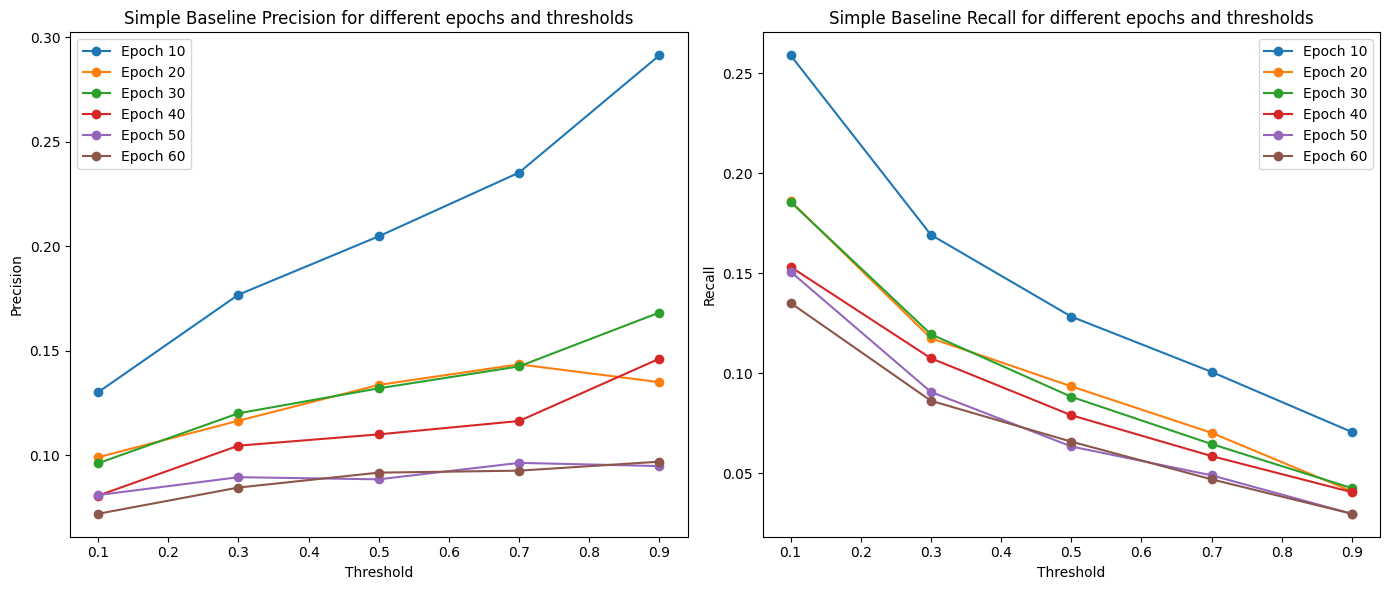

In [29]:
import matplotlib.pyplot as plt

epochs = [10, 20, 30, 40, 50, 60]
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for i, epoch_data in enumerate(performances1):
    precisions, _ = epoch_data
    ax1.plot(thresholds, precisions, 'o-', label=f'Epoch {epochs[i]}')

for i, epoch_data in enumerate(performances1):
    _, recalls = epoch_data
    ax2.plot(thresholds, recalls, 'o-', label=f'Epoch {epochs[i]}')

ax1.set_title('Simple Baseline Precision for different epochs and thresholds')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision')
ax1.legend()

ax2.set_title('Simple Baseline Recall for different epochs and thresholds')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Recall')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

